<a href="https://colab.research.google.com/github/serciex/lane-change/blob/main/V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing Prerequisites

In [85]:
!pip install pygame
!pip install highway-env

Testing

In [86]:
#Import Libraries
from os import truncate
import math
import gymnasium
import highway_env
from matplotlib import pyplot as plt
import pygame
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import gym
from random import randint
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from collections import deque
import random
import torch.optim as optim
import tqdm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from IPython.display import display



# Workaround for gym compatibility
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

%matplotlib inline

Environment Definition

In [87]:
# Configure Environment Conditions
config = {
    "lanes_count": 3,
    "lane_width": 3.75,
    "observation": {
        "type": "Kinematics",
        "features": ["x", "y", "vx", "vy", "heading", "lat_off"]
    },
    "action": {"type": "ContinuousAction"},"ego_spawn_random": True,
    "policy_frequency": 10,
}
env = gymnasium.make('highway-v0', render_mode='rgb_array', config=config)
frames = []

# Action Setup
highway_env.envs.common.action.ContinuousAction(env, lateral=True,
                                                longitudinal=True)

IDM Controller

In [88]:
# Environment Manager
class ENV(env.__class__):
  """
  s = (v,a,x,y,thetha,id,w,c) ∈ S

  Lateral Agent State:
  Obs Data:
  x = vehicle x position (x)
  y = vehicle y position (y)
  v = vehicle speed (vx)
  thetha = yaw angle (heading)

  Input:
  a = longitudinal acceleration (longitudinal_control)
  id = target lane id
  w = lane width
  c = road curvature

  Extra Data:
  vy = lateral rate (vy)
  delta_lat_deviation = change in lateral deviation (lat_off)

  """
  def __init__(self, obs, desired_parameters, control_parameters):
    self.obs = obs
    # Unpack initial parameters: [s0, v0]
    self.s0, self.v0 = desired_parameters

    # Unpack control parameters: [a, b, delta, T]
    self.a, self.b, self.delta, self.T = control_parameters

  def ego_state_idm(self):
      ax, ay, avx, avy, athetha, _ = self.obs[0]
      self._ego_state_idm = {"x": ax, "y": ay, "vx": avx,"thetha": athetha,
                         "longitudinal_acceleration":self.a}

      return self._ego_state_idm

  def update(self,obs):
    self.obs = obs

  def ego_state_agent(self,target_id):
      ax, ay, avx, avy, athetha, _ = self.obs[0]
      vehicle = env.unwrapped.vehicle

      # Control Parameters
      self.id = target_id

      # Environment Parameters
      self.s,_ = vehicle.lane.local_coordinates(vehicle.position)
      self.w = vehicle.lane.width
      self.c = vehicle.lane.heading_at(np.clip(
          vehicle.lane.local_coordinates(vehicle.position)[0],
          0, vehicle.lane.length))
      self.v = math.sqrt(avx**2+avy**2)

      self._ego_state_agent = {"x": ax, "y": ay, "vx": self.v,"thetha": athetha,
                         "lane_width":self.w,"lane_id":self.id,
                         "self_curvature":self.c,
                         "longitudinal_acceleration":self.a}

      return self._ego_state_agent

  def longitudinal_lead_state(self):
      # Lead State Parameters on the same Lane (5 columns: presence, x, y, vx, vy)
      ego_vehicle = env.unwrapped.vehicle
      lead_vehicle = env.unwrapped.road.neighbour_vehicles(ego_vehicle, lane_index=ego_vehicle.lane_index)[0]

      if lead_vehicle:
          gap = lead_vehicle.position[0] - ego_vehicle.position[0]
          delta_velocity = ego_vehicle.velocity[0] - lead_vehicle.velocity[0]
          self._longitudinal_lead_state = {"x": gap, "vx": delta_velocity}
      else:
          self._longitudinal_lead_state = {"x": 10, "vx": 0}

      return self._longitudinal_lead_state

  def idm_controller(self):
      # Unpack input variables: [s, v, delta_v]
      s, v, delta_v = self.longitudinal_lead_state()['x'], self.ego_state_idm()['vx'], self.longitudinal_lead_state()['vx']

      # Small epsilon to account for very small gaps and avoid division by zero
      epsilon = 1e-6

      # Desired gap: s* = s0 + v*T + (v * delta_v) / (2 * sqrt(a * b))
      desired_gap = self.s0 + max(0, v * self.T + ((v * delta_v) / (2 * math.sqrt(self.a * self.b))))

      # IDM acceleration: a_IDM = a * [ 1 - (v / v0)^delta - (s* / s)^2 ]
      acceleration = self.a * (1 - (v / self.v0)**self.delta - (desired_gap / (s + epsilon))**2)

      return acceleration

  #Reward Function
  #Reward Function
  def reward_function(self, obs_old, obs_new, target_id, w1=1, w2=1, w3=0.05):
      """
      Reward Function:

      Acceleration Reward: r_acce = w1*f_acce(a_yaw)
      a_yaw = yaw acceleration (rate of change of yaw rate)

      Rate Reward: r_rate = w2*f_rate(w_yaw)
      w_yaw = yaw rate (rate of change of heading)

      Time Reward: r_time = w3*f_time (delta_lat_deviation)
      delta_lat_deviation = change in lateral deviation (self.lat_off)

      Reward = Cummulative Sum of r_acce + Cummulative Sum of r_rate + Cummulative Sum of r_time

      """

      # Convert direction command to actual target lane
      current_lane_id = env.unwrapped.vehicle.lane_index[2]

      if target_id == +1:  # Move right
          actual_target_lane = min(2, current_lane_id + 1)  # Don't exceed rightmost lane
      elif target_id == -1:  # Move left
          actual_target_lane = max(0, current_lane_id - 1)  # Don't exceed leftmost lane
      else:  # target_id == 0, stay in current lane
          actual_target_lane = current_lane_id

      # Use current vehicle lane structure and set actual target lane
      current_lane_index = list(env.unwrapped.vehicle.lane_index)
      current_lane_index[2] = actual_target_lane  # Only change the lane number to actual lane
      self.target_id = tuple(current_lane_index)

      target_lane_object = env.unwrapped.road.network.get_lane(self.target_id)
      vehicle_s, _ = env.unwrapped.vehicle.lane.local_coordinates(env.unwrapped.vehicle.position)
      _ , self.delta_lat_deviaton = target_lane_object.local_coordinates(env.unwrapped.vehicle.position)

      obs = obs_new[0]
      obs_old = obs_old[0]

      # Extract lateral and longitudinal velocities from observations
      vx_current = obs[2]  # longitudinal velocity
      vy_current = obs[3]  # lateral velocity
      vx_old = obs_old[2]
      vy_old = obs_old[3]

      dt = 1.0 / env.unwrapped.config['policy_frequency']
      L = env.unwrapped.vehicle.LENGTH

      # Calculate both yaw rates in parallel using bicycle model
      vx_vals = np.array([vx_old, vx_current])
      vy_vals = np.array([vy_old, vy_current])

      # Vectorized calculations
      total_velocities = np.sqrt(vx_vals**2 + vy_vals**2)
      curvatures = np.divide(vy_vals, vx_vals * total_velocities + 1e-6,
                            out=np.zeros_like(vy_vals), where=(abs(vx_vals) > 1e-6))
      yaw_rates = total_velocities * curvatures

      previous_yaw_rate, current_yaw_rate = yaw_rates[0], yaw_rates[1]

      w_yaw = current_yaw_rate
      w_yaw_old = previous_yaw_rate

      self.w_acce = (w_yaw-w_yaw_old)*env.unwrapped.config['policy_frequency']

      # Acceleration Reward
      acce_reward = -1*abs(self.w_acce)

      # Rate Reward
      rate_reward = -1*abs(w_yaw)

      # Time Reward
      time_reward = -0.05 * abs(self.delta_lat_deviaton)

      # Overall Reward
      self.reward = w1*acce_reward + w2*rate_reward + w3*time_reward

      return [self.reward, acce_reward, rate_reward, time_reward]

  def action(self, obs, lateral_action):
      self.obs = obs
      L = env.unwrapped.vehicle.LENGTH
      self.acc = self.idm_controller()

      # Calculate steering angle from lateral acceleration
      # self.angle = math.atan(L * lateral_action / self.ego_state_idm()['vx']**2)

      # Return the action as [longitudinal_acceleration, steering_angle]
      calculated_action = [self.acc, lateral_action.item()]

      return calculated_action

Agent Defintion

In [89]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim=8, action_dim=1, hidden_size=256):
        super().__init__()
        self.action_dim = action_dim

        # Policy head (actor) - Output 2 values: mean and log_std
        self.shared = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh()
        )

        self.mu = nn.Sequential(nn.Linear(hidden_size, action_dim),
                                nn.Tanh()
                                )
        self.sigma = nn.Sequential(nn.Linear(hidden_size, action_dim),
                                   nn.Softplus()
                                   )

        # Value head (critic)
        self.critic = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        # Value head
        value = self.critic(x)

        # Policy head
        actor_output = self.shared(x)
        action_mean = self.mu(actor_output)
        action_log_std = self.sigma(actor_output)

        action_log_std = torch.clamp(action_log_std, -20, 2)
        action_std = torch.exp(action_log_std)
        action_dist = torch.distributions.Normal(action_mean, action_std)

        return action_dist, value

    def action(self, state, deterministic = False):
        action_dist, value = self.forward(state)

        if deterministic:
            action = action_dist.mean
            log_prob = action_dist.log_prob(action)

        else:
          action = action_dist.sample()
          log_prob = action_dist.log_prob(action)

        return action, log_prob, value

Lateral Controller (Gap Checker)

In [90]:
import numpy as np

class Gap_Controller(env.__class__):
    def __init__(self, obs=None, following_gap_threshold=30.0, improvement_threshold=10.0):
        # Optionally store an initial observation if provided.
        if obs is not None:
            self.obs = obs
        # Threshold for safety gap with the following vehicle
        self.following_gap_threshold = following_gap_threshold

        # NEW: Require meaningful improvement to justify lane change
        self.improvement_threshold = improvement_threshold

    def lane_checker(self):
        """
        Determines which adjacent lane offers the safest gap for a lane change.
        It examines the current lane, the lane to the left, and the lane to the right,
        returning a direction indicator for the lane change action.
        In addition, if the gap with the following vehicle in the target lane is below the safety
        threshold, the lane change is aborted and the current lane is chosen.

        Returns:
            int: Direction indicator for lane change:
                 +1 for right lane change
                 -1 for left lane change
                  0 for staying in current lane
        """
        lane_number = len(env.unwrapped.road.network.lanes_list())
        ego = env.unwrapped.vehicle

        # Initialize front gap values with a default that indicates an unsafe or non-existent gap.
        gap_current_front = -float('inf')
        gap_right_front = -float('inf')
        gap_left_front = -float('inf')

        # Initialize following gap values (gap between ego and the vehicle behind)
        gap_current_follower = float('inf')
        gap_right_follower = float('inf')
        gap_left_follower = float('inf')

        # Get vehicle neighbours in current lane:
        neighbours_current = env.unwrapped.road.neighbour_vehicles(ego, ego.lane_index)
        # neighbours_current[0] is the vehicle ahead and [1] is the following vehicle.
        if neighbours_current:
            if neighbours_current[0]:
                gap_current_front = neighbours_current[0].position[0] - ego.position[0]
            if len(neighbours_current) > 1 and neighbours_current[1]:
                gap_current_follower = ego.position[0] - neighbours_current[1].position[0]

        # Compute the left and right lane indices.
        current_lane = list(ego.lane_index)
        if current_lane[2] > 0:
            lane_left = (current_lane[0], current_lane[1], current_lane[2] - 1)
        else:
            lane_left = ego.lane_index

        if current_lane[2] < (lane_number - 1):
            lane_right = (current_lane[0], current_lane[1], current_lane[2] + 1)
        else:
            lane_right = ego.lane_index

        # Retrieve neighbour vehicles for the right lane.
        neighbours_right = env.unwrapped.road.neighbour_vehicles(ego, lane_index=lane_right)
        if neighbours_right:
            if neighbours_right[0]:
                gap_right_front = neighbours_right[0].position[0] - ego.position[0]
            if len(neighbours_right) > 1 and neighbours_right[1]:
                gap_right_follower = ego.position[0] - neighbours_right[1].position[0]

        # Retrieve neighbour vehicles for the left lane.
        neighbours_left = env.unwrapped.road.neighbour_vehicles(ego, lane_index=lane_left)
        if neighbours_left:
            if neighbours_left[0]:
                gap_left_front = neighbours_left[0].position[0] - ego.position[0]
            if len(neighbours_left) > 1 and neighbours_left[1]:
                gap_left_follower = ego.position[0] - neighbours_left[1].position[0]

        # NEW: Only change lanes if improvement is significant
        best_alternative_gap = max(gap_right_front, gap_left_front)
        if best_alternative_gap <= gap_current_front + self.improvement_threshold:
            return 0  # Stay in current lane - improvement not worth it

        # Compare the front gaps: current, right, and left.
        front_gaps = [gap_current_front, gap_right_front, gap_left_front]
        best_index = np.argmax(front_gaps)

        # Determine the target lane direction based on the best candidate.
        # best_index: 0 => current lane, 1 => right lane, 2 => left lane.
        if best_index == 1:
            candidate_lane = lane_right
            candidate_follower_gap = gap_right_follower
            direction = 1  # Right turn
        elif best_index == 2:
            candidate_lane = lane_left
            candidate_follower_gap = gap_left_follower
            direction = -1  # Left turn
        else:
            candidate_lane = ego.lane_index
            candidate_follower_gap = gap_current_follower
            direction = 0  # Stay in current lane

        # Check if the candidate lane (if different from the current lane)
        # meets the follower gap condition.
        if candidate_lane != ego.lane_index:
            if candidate_follower_gap < self.following_gap_threshold:
                # The follower gap is too small; do not change lanes.
                return 0  # Stay in current lane
            else:
                return direction  # Return the direction for lane change
        else:
            return 0  # Stay in current lane

Initialize Environment

In [91]:
# Initialize Environment
obs, _ = env.reset()
# IDM Initialization
control_parameters = [0.1, 5, 4, 4]  # a, b, δ, T
desired_parameters = [20, 10.0]       # s0, v0

# Initialize Environment Manager and Reward
state_manager = ENV(obs,control_parameters=control_parameters,desired_parameters=desired_parameters)

# State Manager for Ego and Lead State
ego_state_idm = state_manager.ego_state_idm()
lead_state = state_manager.longitudinal_lead_state()

Training Loop

In [92]:
################################################################################
"""Initialization"""
################################################################################
# Agent Initialization
total_steps_taken = 0

# Tracking for performance
timestep_rewards = []  # Store rewards by timestep
timestep_acce_rewards = []  # Store acceleration rewards
timestep_rate_rewards = []  # Store rate rewards
timestep_time_rewards = []  # Store time rewards
global_returns = []  # Cumulative return tracking
loss_history = []  # Loss values
timesteps_list = []  # Track timesteps for plotting
episode_lengths = []  # Track episode lengths
episode_indices = []  # Track episode indices for plotting

target_id = env.unwrapped.vehicle.lane_index[-1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Environment Information
L = env.unwrapped.vehicle.LENGTH
agent_state = state_manager.ego_state_agent(target_id=target_id)
state_dim = len(agent_state)
action_dim = 1
print(f"State Dimension: {state_dim}, Action Dimension: {action_dim}")

State Dimension: 8, Action Dimension: 1


Model

Plotting

In [93]:
def animate_image_list_efficient(image_list):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create initial image
    im = ax.imshow(image_list[0])
    ax.axis('off')
    title = ax.set_title('Frame 0')

    def animate(frame):
        # Just update the image data - more efficient
        im.set_array(image_list[frame])
        title.set_text(f'Frame {frame}/{len(image_list)}')
        return [im, title]

    anim = FuncAnimation(fig, animate, frames=len(image_list),
                        interval=100, blit=True, repeat=True)
    plt.close()
    return HTML(anim.to_jshtml())

# Initialize plot outside the loop (before the training loop starts)
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

Hyperparameters

In [94]:
# Define hyperparameters
max_timesteps_per_rollout = 500  # Max timesteps per rollout
K = 10    # Number of policy update epochs
test_rate = 5  # Test every 5 batches
num_test = 0
rollout_size = 10

batch_size = 64
gamma = 0.99
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vf_coeff_cl = 0.5
ent_coef_c2 = 0.01
epsilon = 0.1
gae_lambda = 0.99
actor_lr = 5e-5  # Reduced learning rate
critic_lr = 1e-4

# Episode counter
max_episodes_per_rollout = 1
nb_episodes = 100
nb_batches = round(nb_episodes/max_episodes_per_rollout)

# Define action dimension (continuous action space)
action_dim = 1  # For lateral acceleration

# Initialize model and optimizer
model = ActorCritic(state_dim=state_dim, action_dim=action_dim).to(device)
actor_params = list(model.shared.parameters()) + list(model.mu.parameters()) + list(model.sigma.parameters())
critic_params = list(model.critic.parameters())

actor_optimizer = torch.optim.Adam(actor_params, lr=actor_lr)
critic_optimizer = torch.optim.Adam(critic_params, lr=critic_lr)

# Tracking variables
total_env_episodes = 0
max_reward = float('-inf')
batch_average_reward_history = []
batch_episode_history = []
individual_test_rewards = []
individual_test_episodes = []

Training Loop

  0%|          | 0/100 [00:00<?, ?it/s]

Training Batch 1: Collected 112 timesteps Episode Count: 10


  1%|          | 1/100 [00:04<08:07,  4.93s/it]

Training Batch 2: Collected 98 timesteps Episode Count: 10


  3%|▎         | 3/100 [00:14<07:18,  4.52s/it]

Training Batch 3: Collected 91 timesteps Episode Count: 10
Training Batch 4: Collected 155 timesteps Episode Count: 10


  5%|▌         | 5/100 [00:25<08:00,  5.06s/it]

Training Batch 5: Collected 91 timesteps Episode Count: 10
Training Batch 6: Collected 117 timesteps Episode Count: 10


  6%|▌         | 6/100 [00:36<11:06,  7.09s/it]

Episode 5: Avg Test Reward = -13.05, Max Test Reward = -5.13
Training Batch 7: Collected 95 timesteps Episode Count: 10


  7%|▋         | 7/100 [00:40<09:28,  6.11s/it]

Training Batch 8: Collected 120 timesteps Episode Count: 10


  9%|▉         | 9/100 [00:50<08:21,  5.51s/it]

Training Batch 9: Collected 99 timesteps Episode Count: 10
Training Batch 10: Collected 126 timesteps Episode Count: 10


 10%|█         | 10/100 [00:56<08:22,  5.58s/it]

Training Batch 11: Collected 105 timesteps Episode Count: 10


Episode 10: Avg Test Reward = -9.57, Max Test Reward = -5.17


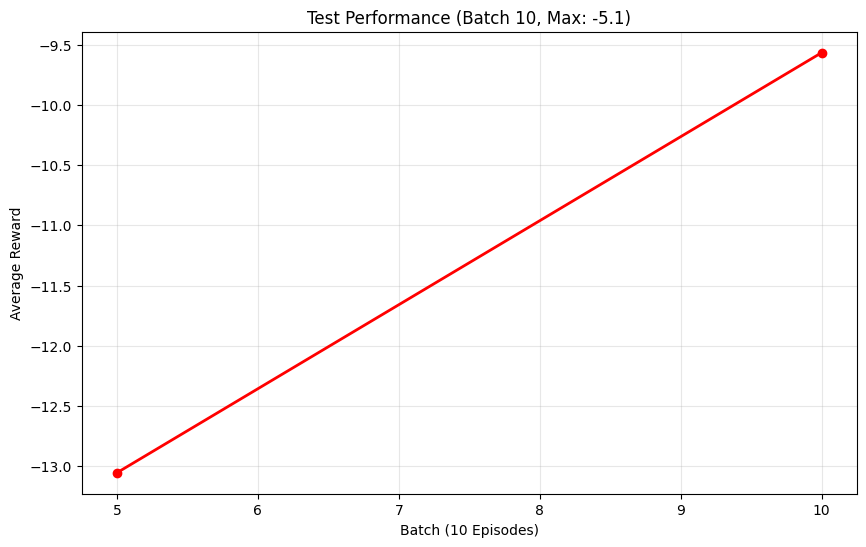

 11%|█         | 11/100 [01:06<10:15,  6.91s/it]

Training Batch 12: Collected 121 timesteps Episode Count: 10


 12%|█▏        | 12/100 [01:12<09:44,  6.64s/it]

Training Batch 13: Collected 131 timesteps Episode Count: 10


 14%|█▍        | 14/100 [01:23<08:31,  5.95s/it]

Training Batch 14: Collected 95 timesteps Episode Count: 10
Training Batch 15: Collected 98 timesteps Episode Count: 10


 15%|█▌        | 15/100 [01:27<07:37,  5.38s/it]

Training Batch 16: Collected 127 timesteps Episode Count: 10


 16%|█▌        | 16/100 [01:38<10:08,  7.25s/it]

Episode 15: Avg Test Reward = -10.76, Max Test Reward = -5.26
Training Batch 17: Collected 125 timesteps Episode Count: 10


 17%|█▋        | 17/100 [01:43<09:07,  6.60s/it]

Training Batch 18: Collected 148 timesteps Episode Count: 10


 18%|█▊        | 18/100 [01:51<09:14,  6.76s/it]

Training Batch 19: Collected 128 timesteps Episode Count: 10


 20%|██        | 20/100 [02:01<07:49,  5.87s/it]

Training Batch 20: Collected 98 timesteps Episode Count: 10
Training Batch 21: Collected 118 timesteps Episode Count: 10


Episode 20: Avg Test Reward = -8.06, Max Test Reward = -4.97


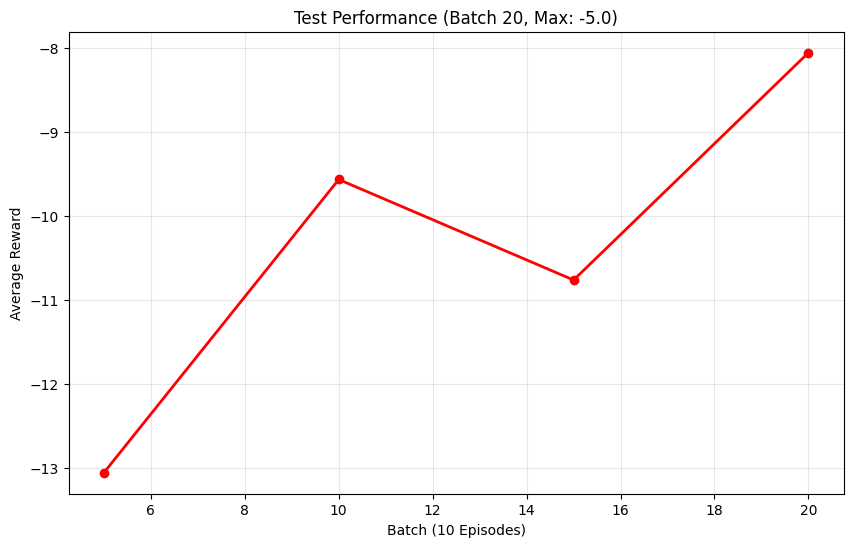

 21%|██        | 21/100 [02:12<09:47,  7.43s/it]

Training Batch 22: Collected 121 timesteps Episode Count: 10


 22%|██▏       | 22/100 [02:17<08:53,  6.83s/it]

Training Batch 23: Collected 158 timesteps Episode Count: 10


 24%|██▍       | 24/100 [02:28<07:29,  5.92s/it]

Training Batch 24: Collected 71 timesteps Episode Count: 10
Training Batch 25: Collected 123 timesteps Episode Count: 10


 25%|██▌       | 25/100 [02:33<07:02,  5.64s/it]

Training Batch 26: Collected 83 timesteps Episode Count: 10


 26%|██▌       | 26/100 [02:41<08:06,  6.57s/it]

Episode 25: Avg Test Reward = -14.66, Max Test Reward = -6.23
Training Batch 27: Collected 126 timesteps Episode Count: 10


 28%|██▊       | 28/100 [02:52<07:07,  5.93s/it]

Training Batch 28: Collected 104 timesteps Episode Count: 10
Training Batch 29: Collected 133 timesteps Episode Count: 10


 30%|███       | 30/100 [03:01<05:49,  5.00s/it]

Training Batch 30: Collected 74 timesteps Episode Count: 10
Training Batch 31: Collected 106 timesteps Episode Count: 10


Episode 30: Avg Test Reward = -14.86, Max Test Reward = -5.07


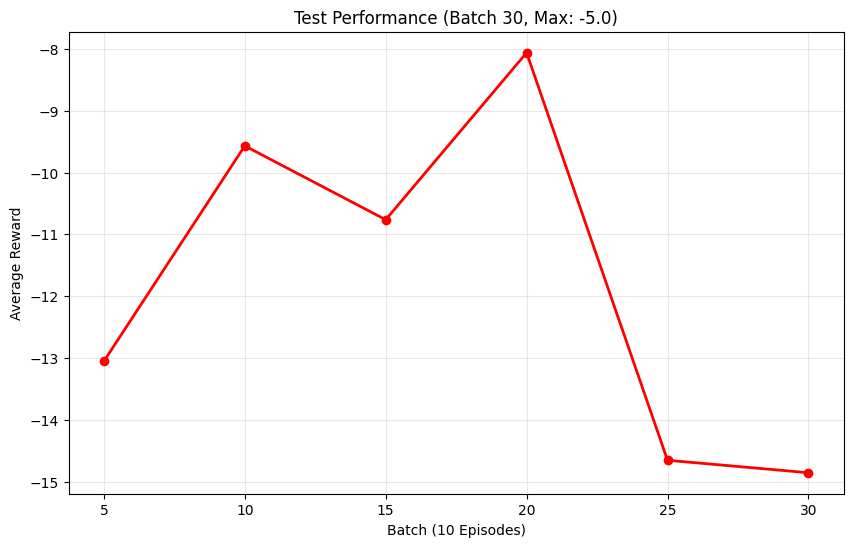

 31%|███       | 31/100 [03:11<07:45,  6.74s/it]

Training Batch 32: Collected 163 timesteps Episode Count: 10


 32%|███▏      | 32/100 [03:19<08:01,  7.07s/it]

Training Batch 33: Collected 142 timesteps Episode Count: 10


 33%|███▎      | 33/100 [03:26<07:39,  6.86s/it]

Training Batch 34: Collected 134 timesteps Episode Count: 10


 34%|███▍      | 34/100 [03:32<07:28,  6.80s/it]

Training Batch 35: Collected 105 timesteps Episode Count: 10


 35%|███▌      | 35/100 [03:37<06:33,  6.05s/it]

Training Batch 36: Collected 87 timesteps Episode Count: 10


 36%|███▌      | 36/100 [03:47<07:55,  7.43s/it]

Episode 35: Avg Test Reward = -14.35, Max Test Reward = -5.39
Training Batch 37: Collected 143 timesteps Episode Count: 10


 37%|███▋      | 37/100 [03:54<07:37,  7.26s/it]

Training Batch 38: Collected 154 timesteps Episode Count: 10


 38%|███▊      | 38/100 [04:00<07:13,  6.99s/it]

Training Batch 39: Collected 124 timesteps Episode Count: 10


 39%|███▉      | 39/100 [04:06<06:40,  6.57s/it]

Training Batch 40: Collected 107 timesteps Episode Count: 10


 40%|████      | 40/100 [04:11<06:00,  6.01s/it]

Training Batch 41: Collected 98 timesteps Episode Count: 10


Episode 40: Avg Test Reward = -9.65, Max Test Reward = -4.77


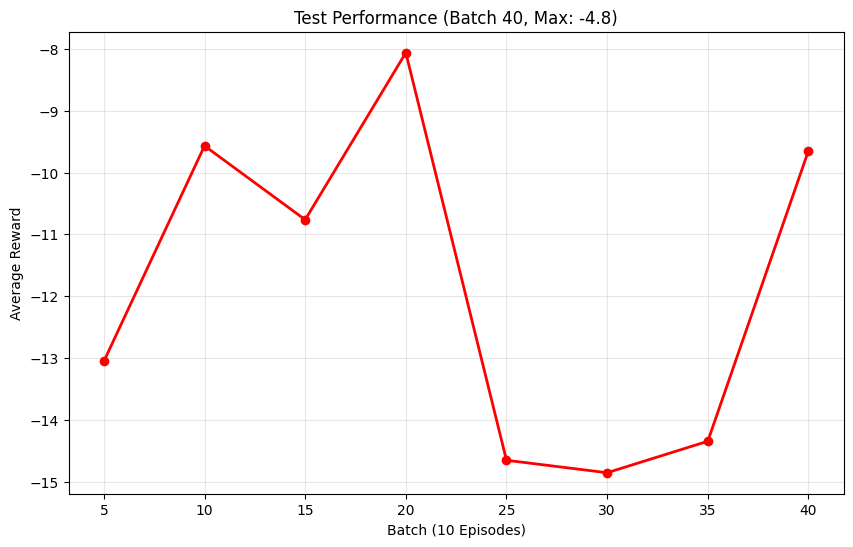

 41%|████      | 41/100 [04:22<07:23,  7.51s/it]

Training Batch 42: Collected 99 timesteps Episode Count: 10


 42%|████▏     | 42/100 [04:26<06:20,  6.55s/it]

Training Batch 43: Collected 96 timesteps Episode Count: 10


 43%|████▎     | 43/100 [04:30<05:32,  5.83s/it]

Training Batch 44: Collected 148 timesteps Episode Count: 10


 45%|████▌     | 45/100 [04:40<04:50,  5.28s/it]

Training Batch 45: Collected 75 timesteps Episode Count: 10
Training Batch 46: Collected 112 timesteps Episode Count: 10


 46%|████▌     | 46/100 [04:51<06:09,  6.85s/it]

Episode 45: Avg Test Reward = -10.23, Max Test Reward = -5.89


 47%|████▋     | 47/100 [04:53<04:50,  5.48s/it]

Training Batch 47: Collected 53 timesteps Episode Count: 10
Training Batch 48: Collected 129 timesteps Episode Count: 10


/tmp/ipython-input-96-178590784.py:161: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(value.squeeze(), b_returns)  # Use pre-calculated returns
 48%|████▊     | 48/100 [05:00<05:06,  5.89s/it]

Training Batch 49: Collected 118 timesteps Episode Count: 10


 49%|████▉     | 49/100 [05:05<04:43,  5.56s/it]

Training Batch 50: Collected 136 timesteps Episode Count: 10


 50%|█████     | 50/100 [05:12<04:57,  5.94s/it]

Training Batch 51: Collected 132 timesteps Episode Count: 10


Episode 50: Avg Test Reward = -12.35, Max Test Reward = -4.93


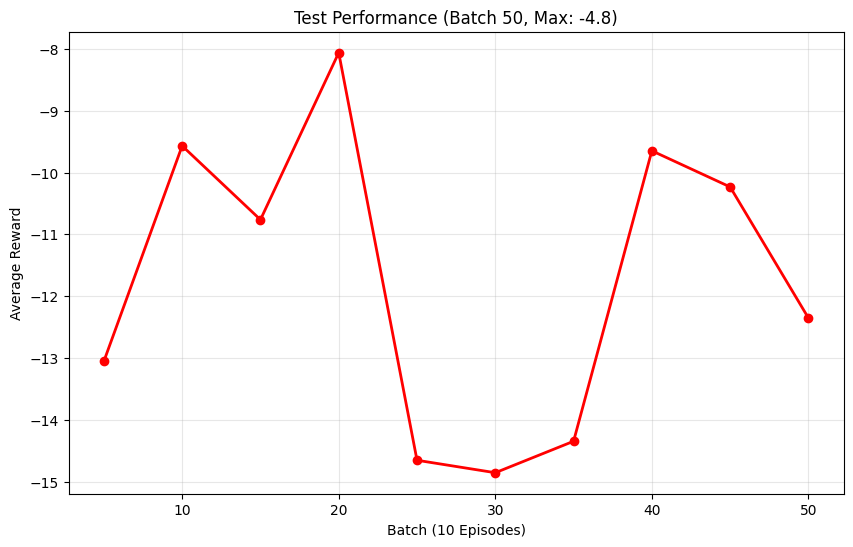

 51%|█████     | 51/100 [05:24<06:30,  7.97s/it]

Training Batch 52: Collected 117 timesteps Episode Count: 10


 53%|█████▎    | 53/100 [05:33<04:40,  5.97s/it]

Training Batch 53: Collected 82 timesteps Episode Count: 10
Training Batch 54: Collected 102 timesteps Episode Count: 10


 54%|█████▍    | 54/100 [05:38<04:28,  5.84s/it]

Training Batch 55: Collected 129 timesteps Episode Count: 10


/tmp/ipython-input-96-178590784.py:161: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(value.squeeze(), b_returns)  # Use pre-calculated returns
 55%|█████▌    | 55/100 [05:44<04:16,  5.71s/it]

Training Batch 56: Collected 112 timesteps Episode Count: 10


 56%|█████▌    | 56/100 [06:04<07:24, 10.10s/it]

Episode 55: Avg Test Reward = -4.76, Max Test Reward = -1.79
Training Batch 57: Collected 149 timesteps Episode Count: 10


 57%|█████▋    | 57/100 [06:10<06:24,  8.94s/it]

Training Batch 58: Collected 165 timesteps Episode Count: 10


 58%|█████▊    | 58/100 [06:18<06:01,  8.60s/it]

Training Batch 59: Collected 153 timesteps Episode Count: 10


 59%|█████▉    | 59/100 [06:24<05:23,  7.90s/it]

Training Batch 60: Collected 162 timesteps Episode Count: 10


 60%|██████    | 60/100 [06:31<05:07,  7.70s/it]

Training Batch 61: Collected 86 timesteps Episode Count: 10


Episode 60: Avg Test Reward = -9.02, Max Test Reward = -3.90


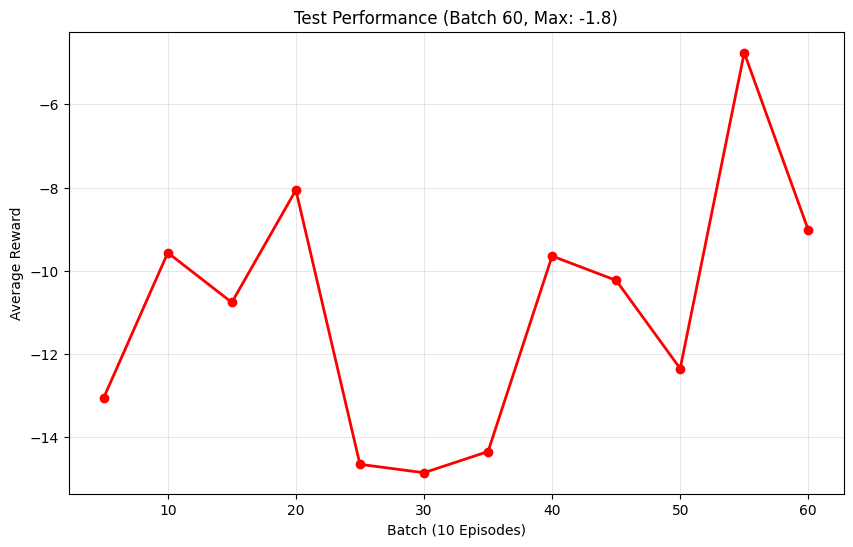

 61%|██████    | 61/100 [06:42<05:38,  8.69s/it]

Training Batch 62: Collected 146 timesteps Episode Count: 10


 63%|██████▎   | 63/100 [06:54<04:23,  7.12s/it]

Training Batch 63: Collected 102 timesteps Episode Count: 10
Training Batch 64: Collected 111 timesteps Episode Count: 10


 64%|██████▍   | 64/100 [06:59<03:52,  6.46s/it]

Training Batch 65: Collected 92 timesteps Episode Count: 10


 65%|██████▌   | 65/100 [07:03<03:22,  5.79s/it]

Training Batch 66: Collected 126 timesteps Episode Count: 10


 66%|██████▌   | 66/100 [07:40<08:31, 15.03s/it]

Episode 65: Avg Test Reward = -3.68, Max Test Reward = -1.97


 67%|██████▋   | 67/100 [07:45<06:39, 12.10s/it]

Training Batch 67: Collected 99 timesteps Episode Count: 10


 68%|██████▊   | 68/100 [07:49<05:08,  9.64s/it]

Training Batch 68: Collected 94 timesteps Episode Count: 10
Training Batch 69: Collected 98 timesteps Episode Count: 10


 70%|███████   | 70/100 [07:58<03:35,  7.18s/it]

Training Batch 70: Collected 109 timesteps Episode Count: 10
Training Batch 71: Collected 87 timesteps Episode Count: 10


Episode 70: Avg Test Reward = -11.32, Max Test Reward = -4.20


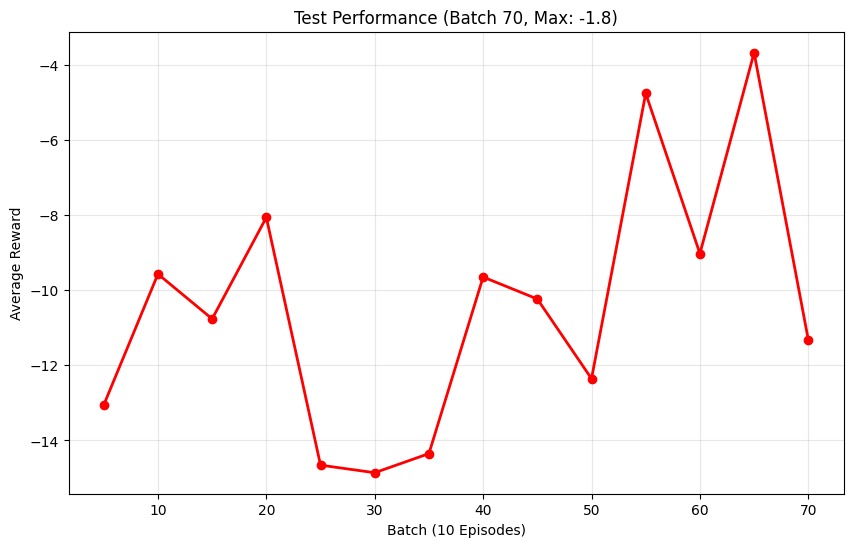

 71%|███████   | 71/100 [08:10<04:07,  8.53s/it]

Training Batch 72: Collected 157 timesteps Episode Count: 10


 72%|███████▏  | 72/100 [08:16<03:40,  7.88s/it]

Training Batch 73: Collected 71 timesteps Episode Count: 10


 74%|███████▍  | 74/100 [08:24<02:35,  5.97s/it]

Training Batch 74: Collected 101 timesteps Episode Count: 10


 75%|███████▌  | 75/100 [08:28<02:13,  5.35s/it]

Training Batch 75: Collected 96 timesteps Episode Count: 10
Training Batch 76: Collected 160 timesteps Episode Count: 10


 76%|███████▌  | 76/100 [08:42<03:09,  7.89s/it]

Episode 75: Avg Test Reward = -12.23, Max Test Reward = -4.77


 77%|███████▋  | 77/100 [08:48<02:45,  7.18s/it]

Training Batch 77: Collected 102 timesteps Episode Count: 10


 78%|███████▊  | 78/100 [08:51<02:16,  6.20s/it]

Training Batch 78: Collected 91 timesteps Episode Count: 10
Training Batch 79: Collected 126 timesteps Episode Count: 10


 80%|████████  | 80/100 [09:02<01:53,  5.69s/it]

Training Batch 80: Collected 99 timesteps Episode Count: 10
Training Batch 81: Collected 107 timesteps Episode Count: 10


Episode 80: Avg Test Reward = -14.42, Max Test Reward = -5.50


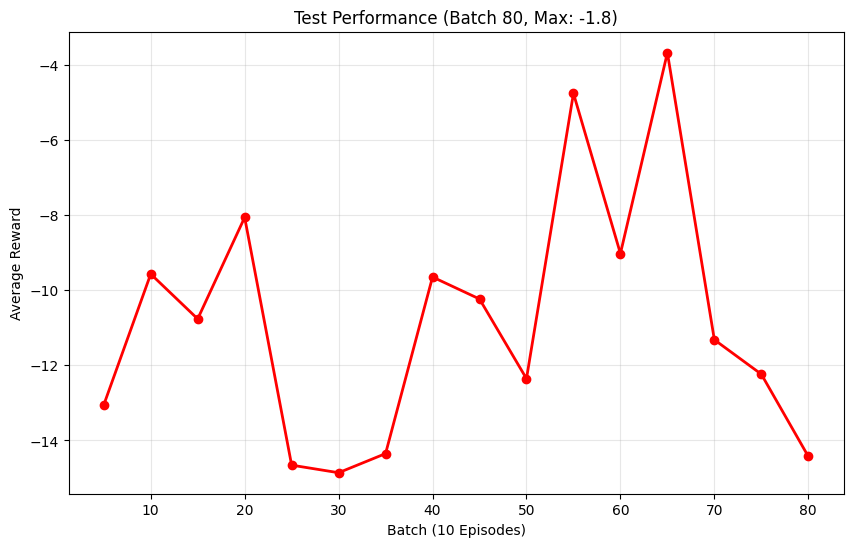

 81%|████████  | 81/100 [09:12<02:13,  7.03s/it]

Training Batch 82: Collected 175 timesteps Episode Count: 10


 82%|████████▏ | 82/100 [09:19<02:06,  7.04s/it]

Training Batch 83: Collected 123 timesteps Episode Count: 10


 83%|████████▎ | 83/100 [09:25<01:55,  6.78s/it]

Training Batch 84: Collected 137 timesteps Episode Count: 10


 84%|████████▍ | 84/100 [09:31<01:42,  6.43s/it]

Training Batch 85: Collected 136 timesteps Episode Count: 10


 85%|████████▌ | 85/100 [09:38<01:37,  6.48s/it]

Training Batch 86: Collected 123 timesteps Episode Count: 10


 86%|████████▌ | 86/100 [09:49<01:49,  7.84s/it]

Episode 85: Avg Test Reward = -13.02, Max Test Reward = -4.99


 87%|████████▋ | 87/100 [09:52<01:26,  6.62s/it]

Training Batch 87: Collected 76 timesteps Episode Count: 10


 88%|████████▊ | 88/100 [09:57<01:11,  5.97s/it]

Training Batch 88: Collected 110 timesteps Episode Count: 10
Training Batch 89: Collected 143 timesteps Episode Count: 10


 89%|████████▉ | 89/100 [10:04<01:09,  6.32s/it]

Training Batch 90: Collected 130 timesteps Episode Count: 10


 90%|█████████ | 90/100 [10:09<01:00,  6.09s/it]

Training Batch 91: Collected 124 timesteps Episode Count: 10


Episode 90: Avg Test Reward = -6.70, Max Test Reward = -3.45


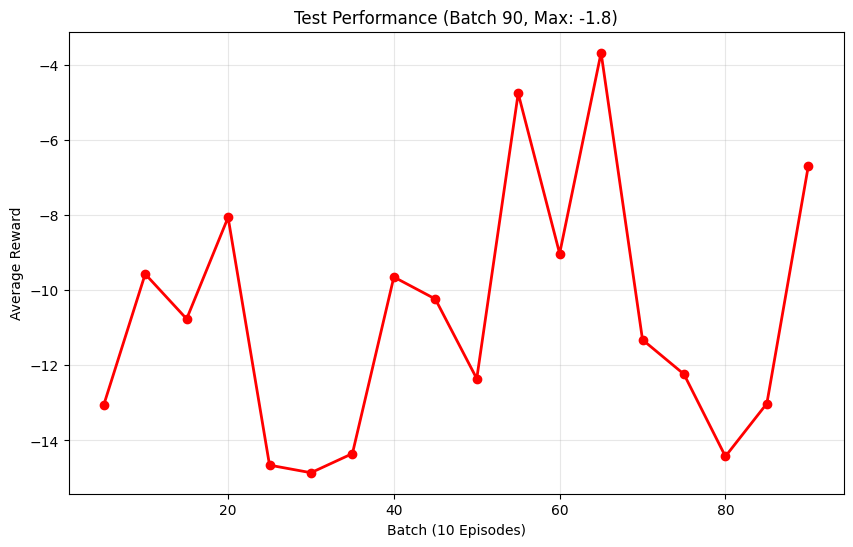

 91%|█████████ | 91/100 [10:26<01:22,  9.16s/it]

Training Batch 92: Collected 107 timesteps Episode Count: 10


 92%|█████████▏| 92/100 [10:31<01:04,  8.00s/it]/tmp/ipython-input-96-178590784.py:161: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(value.squeeze(), b_returns)  # Use pre-calculated returns
 93%|█████████▎| 93/100 [10:34<00:45,  6.46s/it]

Training Batch 93: Collected 65 timesteps Episode Count: 10
Training Batch 94: Collected 104 timesteps Episode Count: 10


 94%|█████████▍| 94/100 [10:39<00:35,  5.90s/it]

Training Batch 95: Collected 128 timesteps Episode Count: 10


 95%|█████████▌| 95/100 [10:45<00:30,  6.03s/it]

Training Batch 96: Collected 125 timesteps Episode Count: 10


 96%|█████████▌| 96/100 [10:57<00:31,  7.96s/it]

Episode 95: Avg Test Reward = -12.54, Max Test Reward = -5.10


In [ ]:
for batch in tqdm.tqdm(range(nb_batches)):

    # PPO Initialization
    max_possible_steps = max_timesteps_per_rollout * rollout_size

    # Temporary storage lists
    temp_states = []
    temp_actions = []
    temp_log_probs = []
    temp_state_values = []
    temp_rewards = []
    temp_is_terminal = []

    # Env Initialization
    obs, _ = env.reset()
    state_manager.update(obs)

    # Initialize target_id
    target_id = env.unwrapped.vehicle.lane_index[-1]
    agent_state = state_manager.ego_state_agent(target_id=target_id)

    # Episode Reset
    obs, _ = env.reset()
    state_manager.update(obs)
    done = False
    obs_old = obs
    episode_step = 0
    episode_return = 0.0
    timestep_counter = 0
    rollout = 0

    while not done and rollout < rollout_size:
        gap_control = Gap_Controller(obs, following_gap_threshold=30)
        activated_target_lane = gap_control.lane_checker()

        # Determine target lane
        target_id = activated_target_lane
        agent_state = state_manager.ego_state_agent(target_id=target_id)

        # Convert agent state dict to tensor
        state_tensor = torch.tensor(
            [agent_state[key] for key in ['vx', 'longitudinal_acceleration', 'x', 'y', 'thetha', 'lane_id', 'lane_width', 'self_curvature']],
            dtype=torch.float32, device=device
        ).unsqueeze(0)

        # Get action and value from model
        with torch.no_grad():
            agent_action, log_prob, value = model.action(state_tensor)
            action = state_manager.action(obs,agent_action)

        # Take action in environment
        obs, reward, done, truncated, info = env.step(action)
        done = done or truncated

        # Terminal conditions
        if info["crashed"] or not env.unwrapped.vehicle.on_road or timestep_counter >= max_timesteps_per_rollout:
            done = True

        # Update state manager with new observation and applied longitudinal control
        state_manager.update(obs)

        # Compute reward based on the new state
        reward_components = state_manager.reward_function(obs_old, obs, target_id)
        reward = reward_components[0]

        # Store trajectory information in lists
        temp_states.append(state_tensor.squeeze(0))
        temp_actions.append(agent_action)
        temp_log_probs.append(log_prob)
        temp_state_values.append(value.squeeze())
        temp_rewards.append(torch.tensor(reward, dtype=torch.float32, device=device))
        temp_is_terminal.append(done)

        timestep_counter += 1
        obs_old = obs

        # If episode is done, increment rollout and reset for next episode
        if done:
            rollout += 1
            if rollout < rollout_size:
                obs, _ = env.reset()
                state_manager.update(obs)
                done = False
                obs_old = obs

    actual_timesteps = len(temp_states)

    buffer_states = torch.stack(temp_states)  # Shape: [actual_timesteps, state_dim]
    buffer_actions = torch.stack(temp_actions)  # Shape: [actual_timesteps, action_dim]
    buffer_log_probs = torch.stack(temp_log_probs)  # Shape: [actual_timesteps]
    buffer_state_values = torch.stack(temp_state_values)  # Shape: [actual_timesteps]
    buffer_rewards = torch.stack(temp_rewards)  # Shape: [actual_timesteps]
    buffer_is_terminal = torch.tensor(temp_is_terminal, dtype=torch.float32, device=device)  # Shape: [actual_timesteps]

    # Print rollout info
    print(f"Training Batch {batch+1}: Collected {actual_timesteps} timesteps Episode Count: {rollout}")

    # Calculate advantages using GAE
    gae = 0
    advantages = torch.zeros(actual_timesteps, dtype=torch.float32, device=device)

    # Calculate advantages using GAE
    gae = 0
    advantages = torch.zeros(actual_timesteps, dtype=torch.float32, device=device)

    for step_idx in range(actual_timesteps-1, -1, -1):
        if buffer_is_terminal[step_idx]:
            terminal = 1
            next_value = 0
        else:
            terminal = 0
            if step_idx == actual_timesteps-1:
                next_value = 0
            else:
                next_value = buffer_state_values[step_idx+1]

        delta = buffer_rewards[step_idx] + gamma * next_value * (1-terminal) - buffer_state_values[step_idx]
        gae = delta + (gamma * gae_lambda) * gae * (1-terminal)
        advantages[step_idx] = gae

        # FIXED: Reset GAE at episode boundaries
        if buffer_is_terminal[step_idx]:
            gae = 0

    # Normalize advantages (recommended for stable training)
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    # Calculate returns
    returns = advantages + buffer_state_values

    # Prepare data for policy update
    advantages_data_loader = DataLoader(
        TensorDataset(
            advantages.detach(),
            returns.detach(),              # Add pre-calculated returns
            buffer_states.detach(),
            buffer_actions.detach(),
            buffer_log_probs.detach(),
            buffer_state_values.detach()),
        batch_size=min(batch_size, actual_timesteps),
        shuffle=True)

    # Policy update (K epochs)
    for epoch in range(K):
        for batch_data in advantages_data_loader:
            b_adv, b_returns, obs_batch, action_batch, old_log_probs, old_state_values = batch_data

            # Forward pass
            dist, value = model(obs_batch)
            log_probs = dist.log_prob(action_batch)

            # Calculate ratio
            ratio = torch.exp(log_probs - old_log_probs)

            # Policy loss - use b_adv consistently
            policy_loss_1 = b_adv * ratio
            policy_loss_2 = b_adv * torch.clamp(ratio, 1-epsilon, 1+epsilon)
            policy_loss = -torch.min(policy_loss_1, policy_loss_2).mean()

            actor_loss = policy_loss - ent_coef_c2 * dist.entropy().mean()
            critic_loss = F.mse_loss(value.squeeze(), b_returns)  # Use pre-calculated returns

            # Optimize
            actor_optimizer.zero_grad()
            actor_loss.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(actor_params, max_norm=0.5)
            actor_optimizer.step()

            critic_optimizer.zero_grad()
            critic_loss.backward()
            torch.nn.utils.clip_grad_norm_(critic_params, max_norm=0.5)
            critic_optimizer.step()

    # Testing section
    if batch % test_rate == 0 and batch > 0:
        num_test = 1
        test_rewards = []
        frames = []
        time = []
        state_manager = ENV(obs,control_parameters=control_parameters,desired_parameters=desired_parameters)

        for test_ep in range(10):
            obs, _ = env.reset()
            obs_old = obs
            episode_reward = 0
            done = False
            test_step_counter = 0  # FIXED: Different variable name
            state_manager.update(obs)

            while not done and test_step_counter < 500:
                gap_control = Gap_Controller(obs, following_gap_threshold=30)
                activated_target_lane = gap_control.lane_checker()

                target_id = activated_target_lane
                agent_state = state_manager.ego_state_agent(target_id=target_id)

                state_tensor = torch.tensor(
                    [agent_state[key] for key in ['vx', 'longitudinal_acceleration', 'x', 'y', 'thetha', 'lane_id', 'lane_width', 'self_curvature']],
                    dtype=torch.float32, device=device
                ).unsqueeze(0)

                with torch.no_grad():
                    agent_action, log_prob, value = model.action(state_tensor,deterministic=True)

                action = state_manager.action(obs, agent_action)

                obs, _, done, truncated, info = env.step(action)
                done = done or truncated

                if test_ep % 5 == 0:
                    image = env.render()
                    frames.append(image)

                # Terminal conditions
                if info["crashed"] or not env.unwrapped.vehicle.on_road or test_step_counter >= 500:
                    done = True

                state_manager.update(obs)
                reward_components = state_manager.reward_function(obs_old, obs, target_id)
                reward = reward_components[0]

                episode_reward += reward
                test_step_counter += 1  # FIXED: Use test_step_counter
                obs_old = obs

            test_rewards.append(episode_reward)

        # Animation and plotting code stays the same...
        display(animate_image_list_efficient(frames))

        avg_test_reward = sum(test_rewards) / len(test_rewards)
        current_max = max(test_rewards)

        if current_max > max_reward:
            max_reward = current_max

        batch_average_reward_history.append(avg_test_reward)
        batch_episode_history.append(batch)
        print(f"Episode {batch}: Avg Test Reward = {avg_test_reward:.2f}, Max Test Reward = {current_max:.2f}")

    # Plot every 10 batches
    if batch % 10 == 0 and batch > 0 and len(batch_average_reward_history) > 0:
        plt.figure(figsize=(10, 6))
        plt.plot(batch_episode_history, batch_average_reward_history, 'r-o', linewidth=2)
        plt.title(f"Test Performance (Batch {batch}, Max: {max_reward:.1f})")
        plt.xlabel("Batch (10 Episodes)")
        plt.ylabel("Average Reward")
        plt.grid(True, alpha=0.3)
        plt.show()

print("Training completed!")